# When is Multicollinearity an Issue?

> A causal example

In [ ]:
#| default_exp multicollinearity

In [ ]:
#| hide
from nbdev.showdoc import *
import pprint
from itertools import product
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pymc as pm
from tueplots import bundles
from tueplots.constants.color import rgb
import seaborn as sns
from common_regression_issues.utils.plotting import rgb_to_hex

In [ ]:
#| export
#| hide
import xarray as xr
import pandas as pd
import numpy as np

In [ ]:
#| hide
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#| hide
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

## The Causal Model (and Related Syntax)

I will be using @fig-causal-graph for the rest of the examples on this page. 

Edges will be colored to highlight if they represent causal paths (green <button disabled style="background-color: #326E1E; height: 13px; width: 11px;"></button>), biasing paths (red <button disabled style="background-color: #8D2D39; height: 13px; width: 11px;"></button>), or non-causal paths (black <button disabled style="background-color: #000000; height: 13px; width: 11px;"></button>). See @fig-causal-graph-paid-search and @fig-causal-graph-paid-search-adjusted 

Nodes that represent exposures (things for which we would like to know the effect of) will be filled with a green (<button disabled style="background-color: #82B9A0; height: 13px; width: 11px;"></button>) background. The outcome variable of interest will be filled with a blue background (<button disabled style="background-color: #0069AA; height: 13px; width: 11px;"></button>). Variables that are adjusted for are filled with a light gray color (<button disabled style="background-color: #AFB3B7; height: 13px; width: 11px;"></button>) Nodes with a dashed outline are difficult if not impossible to directly observe. Nodes that are not filled and have a solid outline are variables for which we have data (or  for which data can be aqcuired).

::: {.panel-tabset}
## Causal Model
```{dot}
//| label: fig-causal-graph
//| fig-cap: The causal graph incoding our assumptions of the data generating process, for the following example. This model may not be entirely accurate and should be reviewed with both experts and stakeholders to further improve the graph's structure, and to include as many factors that may impact the variables of interest as possible.
//| fig-cap-location: bottom

digraph "Paid Media on Sales" {
  Seasonality;
  Seasonality -> "OLV Impression";
  "OLV Impression" -> Demand;
  Seasonality -> Demand;
  Seasonality -> "Social Impression";
  "Social Impression" -> Demand;
  "Search Query" -> Auction;
  "Search Query" -> "Paid Search Impression";
  Auction -> "Paid Search Impression";
  Demand -> "Search Query";
  Seasonality -> "Search Query";
  "Paid Search Impression" -> "Paid Search Click";
  Demand -> "Paid Search Click";
  "Search Query" -> "Paid Search Click";
  "Search Query" -> "Organic Search";
  "Organic Search" -> Sales;
  Demand -> Sales;
  "Paid Search Click" -> Sales;
  Price -> Demand;
  Price -> Sales;
}
```

## Un-Adjusted
```{dot}
//| label: fig-causal-graph-paid-search
//| fig-cap: Example causal graph for paid search on sales, with no variables adjusted for all biased paths are open. We want to adjust for enough variables to ensure that biasing paths are closed, and some variables to reduce the variance of the estimate of the effect of **Paid Search Impressions** on **Sales**
//| fig-cap-location: bottom

digraph "Paid Media on Sales" {
  //Exposure
  "Paid Search Impression" [color="#7DA54B" fillcolor="#82B9A0" style=filled];
  //Outcome
  Sales [fillcolor="#0069AA" fontcolor=white style=filled];
  //Adjusted
  //Price [fillcolor="#AFB3B7" style=filled]
  //Un-Observed
  "OLV Impression", "Social Impression" [color="#AFB3B7"]; 
  "Search Query", "Paid Search Click", Price, "Organic Search" [color="#AFB3B7"];
  //Un-Observable
  Seasonality, Demand, Auction [color="#AFB3B7" style=dashed];
  Seasonality -> "OLV Impression" [color="#8D2D39"];
  "OLV Impression" -> Demand [color="#8D2D39"];
  Seasonality -> Demand [color="#8D2D39"];
  Seasonality -> "Social Impression" [color="#8D2D39"];
  "Social Impression" -> Demand [color="#8D2D39"];
  "Search Query" -> Auction [color="#8D2D39"];
  "Search Query" -> "Paid Search Impression" [color="#8D2D39"];
  Auction -> "Paid Search Impression" [color="#8D2D39"];
  Demand -> "Search Query" [color="#8D2D39"];
  Seasonality -> "Search Query" [color="#8D2D39"];
  "Paid Search Impression" -> "Paid Search Click" [color="#8D2D39" style=bold];
  Demand -> "Paid Search Click" [color="#8D2D39"];
  "Search Query" -> "Paid Search Click" [color="#8D2D39"];
  "Search Query" -> "Organic Search" [color="#8D2D39"];
  "Organic Search" -> Sales [color="#8D2D39"];
  Demand -> Sales [color="#8D2D39"];
  "Paid Search Click" -> Sales [color="#8D2D39" style=bold];
  Price -> Demand [color="#8D2D39"];
  Price -> Sales [color="#8D2D39"];
}
```

## Correctly Adjusted
```{dot}
//| label: fig-causal-graph-paid-search-adjusted
//| fig-cap: By adjusting for **Search Query** all biased paths are closed. **Price** is also being adjusted for this is not to close biasing paths but to reduce the variance of the effect of **Paid Search Impressions** on **Sales**
//| fig-cap-location: bottom

digraph "Paid Media on Sales" {
  //Exposure
  "Paid Search Impression" [color="#7DA54B" fillcolor="#82B9A0" style=filled];
  //Outcome
  Sales [fillcolor="#0069AA" fontcolor=white style=filled];
  //Adjusted
  Price, "Search Query" [fillcolor="#AFB3B7" style=filled]
  //Un-Observed
  "OLV Impression", "Social Impression" [color="#AFB3B7"]; 
  "Paid Search Click", "Organic Search" [color="#AFB3B7"];
  //Un-Observable
  Seasonality, Demand, Auction [color="#AFB3B7" style=dashed];
  Seasonality -> "OLV Impression";
  "OLV Impression" -> Demand;
  Seasonality -> Demand;
  Seasonality -> "Social Impression";
  "Social Impression" -> Demand;
  "Search Query" -> Auction;
  "Search Query" -> "Paid Search Impression";
  Auction -> "Paid Search Impression";
  Demand -> "Search Query";
  Seasonality -> "Search Query";
  "Paid Search Impression" -> "Paid Search Click" [color="#326E1E" style=bold];
  Demand -> "Paid Search Click";
  "Search Query" -> "Paid Search Click";
  "Search Query" -> "Organic Search";
  "Organic Search" -> Sales;
  Demand -> Sales;
  "Paid Search Click" -> Sales [color="#326E1E" style=bold];
  Price -> Demand;
  Price -> Sales;
  Seasonality -> Sales;
}
```

:::

In [ ]:
#| export
def sample_random_data(
    N_weeks: int, # Number of weeks to generate
    include_hidden_confounds:bool=False, # Should hidden confounds be included in the dataset
    random_seed: int|None = None, # Random Seed
) -> xr.Dataset: # Dataset containing the variables described by the above causal model
    t = np.linspace(0, (N_weeks-1)/52., N_weeks)
    dates = pd.date_range("2021-01-01", periods=N_weeks, freq="W-MON")
    rng = np.random.default_rng(random_seed)

    ## Define Seasonal component
    seasonal_coeffs_sin = rng.normal(0, 2, 3)/np.arange(1, 4)**2
    seasonal_coeffs_cos = rng.normal(0, 2, 3)/np.arange(1, 4)**2
    season = (
        np.stack([np.sin(i*2*np.pi*t) for i in range(1, 4)]).T @ seasonal_coeffs_sin
        + np.stack([np.cos(i*2*np.pi*t) for i in range(1, 4)]).T @ seasonal_coeffs_cos
    )
    season = xr.DataArray(season, coords={"Period": dates}, dims="Period")

    ## Define Price Movements
    return season

[<matplotlib.lines.Line2D>]

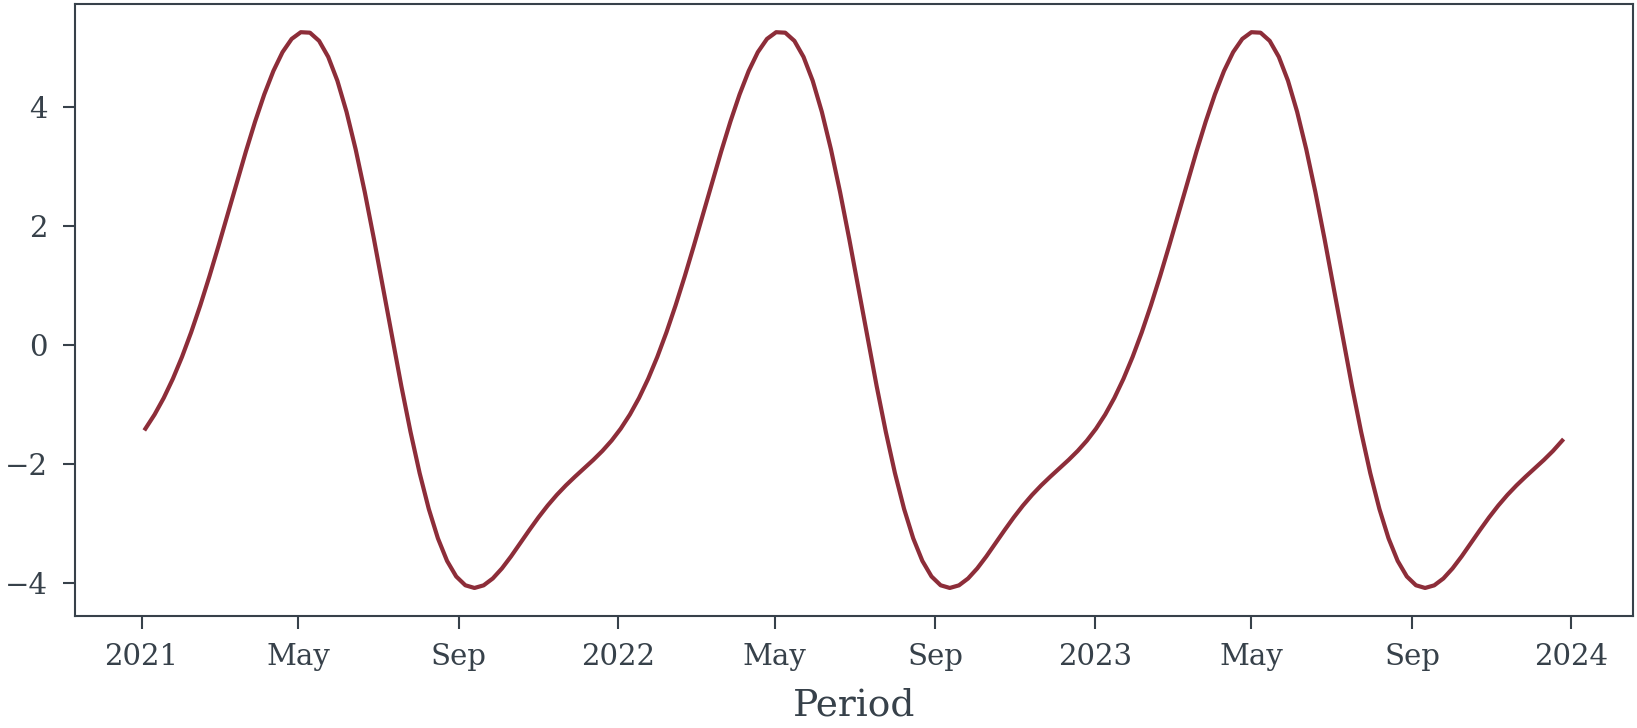

In [ ]:
sample_random_data(156, random_seed=3).plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()